In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define file paths based on our folder structure
RAW_DATA_PATH = '../data/raw/complaints.csv'
PROCESSED_DATA_PATH = '../data/processed/filtered_complaints.csv'

# Load the full dataset
try:
    df = pd.read_csv(RAW_DATA_PATH, dtype={'ZIP code': str})
    print("Dataset loaded successfully.")
    print(f"Original dataset shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {RAW_DATA_PATH}. Please ensure the dataset is in the correct directory.")
    # Exit or handle the error appropriately

C:\Users\Yoga i7\AppData\Local\Temp\ipykernel_7744\2029152639.py:17: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATA_PATH, dtype={'ZIP code': str})


Dataset loaded successfully.
Original dataset shape: (9609797, 18)



Distribution of complaints per product:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Name: count, dtype: int64


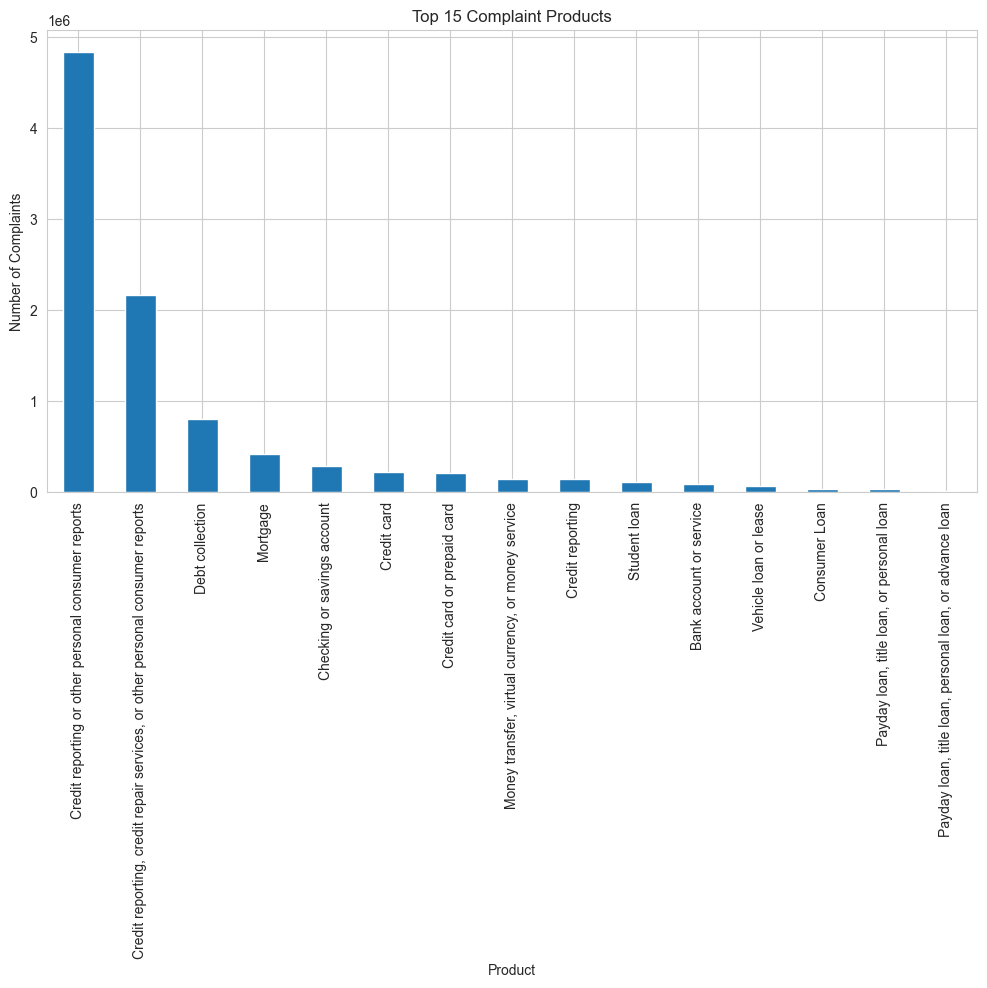


Statistics for Narrative Word Count:
count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: narrative_word_count, dtype: float64


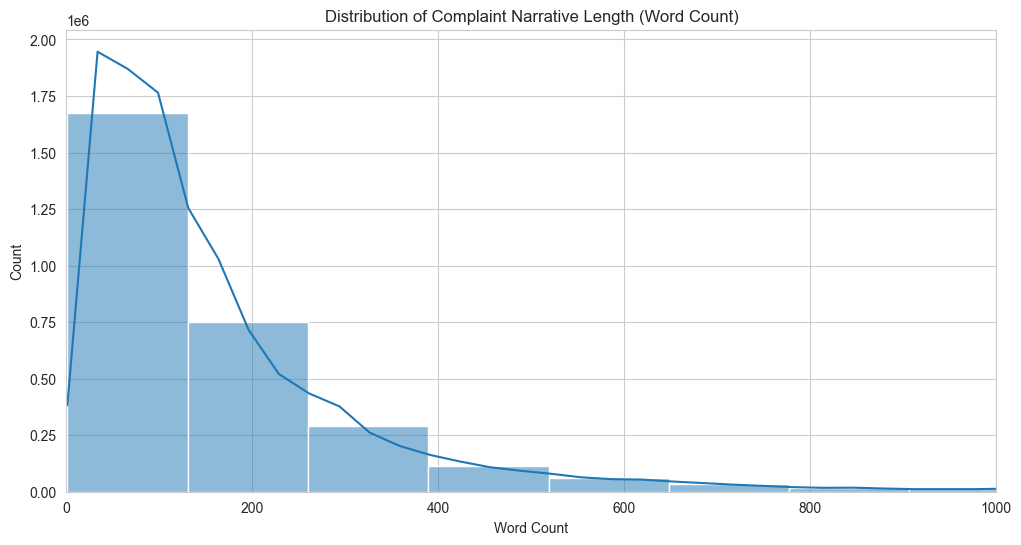


Total complaints: 9609797
Complaints with narratives: 2980756 (31.02%)
Complaints without narratives: 6629041 (68.98%)


In [2]:
# 1. Analyze the distribution of complaints across different Products
print("\nDistribution of complaints per product:")
product_counts = df['Product'].value_counts()
print(product_counts.head(10)) # Display top 10

# Visualize the distribution
product_counts.head(15).plot(kind='bar', title='Top 15 Complaint Products')
plt.ylabel('Number of Complaints')
plt.show()

# 2. Analyze the length of the 'Consumer complaint narrative'
# First, drop rows where the narrative is missing for this analysis
df_narratives = df.dropna(subset=['Consumer complaint narrative']).copy()
df_narratives['narrative_word_count'] = df_narratives['Consumer complaint narrative'].apply(lambda x: len(x.split()))

print("\nStatistics for Narrative Word Count:")
print(df_narratives['narrative_word_count'].describe())

# Visualize the narrative length distribution
sns.histplot(df_narratives['narrative_word_count'], bins=50, kde=True)
plt.title('Distribution of Complaint Narrative Length (Word Count)')
plt.xlabel('Word Count')
plt.xlim(0, 1000) # Limiting x-axis for better readability
plt.show()

# 3. Identify the number of complaints with and without narratives
total_complaints = len(df)
complaints_with_narratives = df['Consumer complaint narrative'].notna().sum()
complaints_without_narratives = df['Consumer complaint narrative'].isna().sum()

print(f"\nTotal complaints: {total_complaints}")
print(f"Complaints with narratives: {complaints_with_narratives} ({complaints_with_narratives/total_complaints:.2%})")
print(f"Complaints without narratives: {complaints_without_narratives} ({complaints_without_narratives/total_complaints:.2%})")

In [3]:
# 1. Filter for the five specified products
target_products = [
    'Credit card or prepaid card', # Note: The dataset uses 'Credit card or prepaid card' for credit cards
    'Personal loan', 
    'Payday loan, title loan, or personal loan', # This category also includes personal loans
    'Checking or savings account', # This covers Savings Accounts
    'Money transfer, virtual currency, or money service', # Covers Money Transfers and BNPL can fall here
]

# Let's refine the product names for clarity later.
# We can map the original long names to the simpler names CrediTrust uses.
product_mapping = {
    'Credit card or prepaid card': 'Credit Card',
    'Personal loan': 'Personal Loan',
    'Payday loan, title loan, or personal loan': 'Personal Loan',
    'Checking or savings account': 'Savings Account',
    'Money transfer, virtual currency, or money service': 'Money Transfers'
}

# Filter rows where the product is in our list
df_filtered = df[df['Product'].isin(product_mapping.keys())].copy()

# Map to our simplified product names
df_filtered['Product'] = df_filtered['Product'].map(product_mapping)

print(f"\nShape after filtering for target products: {df_filtered.shape}")

# 2. Remove records with empty 'Consumer complaint narrative' fields
df_filtered.dropna(subset=['Consumer complaint narrative'], inplace=True)
print(f"Shape after removing empty narratives: {df_filtered.shape}")


# 3. Clean the text narratives
def clean_text(text):
    """
    Cleans a given text by:
    - Lowercasing
    - Removing boilerplate text
    - Removing special characters
    - Removing extra whitespace
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    
    # Remove common boilerplate phrases (can be expanded)
    boilerplate = [
        "i am writing to file a complaint",
        "this is a complaint about",
        # The CFPB often adds this part, which is not from the user
        "in accordance with the fair credit reporting act", 
    ]
    for phrase in boilerplate:
        text = text.replace(phrase, "")
        
    # Remove special characters, keeping only letters, numbers, and whitespace
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    # Remove "xx" placeholders which are common in this dataset
    text = re.sub(r'\b(x{2,})\b', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

# Apply the cleaning function
print("\nCleaning text narratives...")
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

# Display a before-and-after example
print("\n--- Cleaning Example ---")
original_text = df_filtered['Consumer complaint narrative'].iloc[0]
cleaned_text = df_filtered['cleaned_narrative'].iloc[0]
print(f"Original:\n{original_text[:300]}...\n")
print(f"Cleaned:\n{cleaned_text[:300]}...")
print("------------------------")


Shape after filtering for target products: (673254, 18)
Shape after removing empty narratives: (363412, 18)

Cleaning text narratives...

--- Cleaning Example ---
Original:
I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. 

I went into the branch and was told they couldn't help and had to phone the customer service for help. I did this and was told I was helped gave all the info for the time terminal i...

Cleaned:
i made the mistake of using my wellsfargo debit card to depsit funds into atm machine outside their branch i went into the branch and was told they couldnt help and had to phone the customer service for help i did this and was told i was helped gave all the info for the time terminal id aact s was a...
------------------------


In [4]:
# Select relevant columns for the final dataset
final_columns = [
    'Date received',
    'Product',
    'Issue',
    'Consumer complaint narrative',
    'cleaned_narrative',
    'Company',
    'State',
    'Complaint ID'
]

df_final = df_filtered[final_columns].copy()

# Remove any rows where the cleaned narrative became empty after processing
df_final = df_final[df_final['cleaned_narrative'] != '']

# Save to CSV
try:
    df_final.to_csv(PROCESSED_DATA_PATH, index=False)
    print(f"\nCleaned and filtered dataset saved successfully to {PROCESSED_DATA_PATH}")
    print(f"Final dataset shape: {df_final.shape}")
except Exception as e:
    print(f"Error saving file: {e}")


Cleaned and filtered dataset saved successfully to ../data/processed/filtered_complaints.csv
Final dataset shape: (363409, 8)
